# Assignment 1

## Decision Tree Classifier

In [622]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

In [623]:
column_names = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation',
    'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income'
]

train_data = pd.read_csv('Census Income Data Set/adult.data', names=column_names, sep=' *, *', na_values='?', engine='python')
test_data = pd.read_csv('Census Income Data Set/adult.test', names=column_names, sep=' *, *', skiprows=1, na_values='?',engine='python')

### Check for missing values

In [624]:
print("train_data null values:\n",train_data.isnull().sum(), "\n")
print("test_data null values:",test_data.isnull().sum().sum())

train_data null values:
 age                  0
workclass         1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
income               0
dtype: int64 

test_data null values: 2203


### Data pre-processing

In [625]:
train_data['net-capital'] = train_data['capital-gain'] - train_data['capital-loss']
test_data['net-capital'] = test_data['capital-gain'] - test_data['capital-loss']

train_data = train_data[train_data['native-country'] != 'Holand-Netherlands']
test_data = test_data[test_data['native-country'] != 'Holand-Netherlands']

to_drop = ['education', 'fnlwgt', 'capital-gain', 'capital-loss']
train_data.drop(to_drop, inplace=True, axis=1)
test_data.drop(to_drop, inplace=True, axis=1)

In [626]:
train_copy = train_data.copy()
train_copy["income"] = train_copy["income"].apply(lambda x:0 if x=='<=50K' else 1)

test_copy = test_data.copy()
test_copy["income"] = test_copy["income"].apply(lambda x:0 if x=='<=50K.' else 1)

X_train = train_copy.drop('income', axis=1)
y_train = train_copy['income']

X_test = test_copy.drop('income', axis=1)
y_test = test_copy['income']

In [627]:
categorical_columns = ['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
numerical_columns = ['age', 'education-num', 'hours-per-week', 'net-capital']

scaler = StandardScaler()
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.fit_transform(X_test[numerical_columns])

# z = np.abs(stats.zscore(X_train[numerical_columns], axis=1))
# threshold = 3
# X_train = X_train[(z < 3).all(axis=1)]

for column in categorical_columns:
    most_frequent_category = train_data[column].mode()[0]
    train_data[column].fillna(most_frequent_category, inplace=True)

X_train = pd.get_dummies(X_train, columns=categorical_columns, drop_first=True)
X_test = pd.get_dummies(X_test, columns=categorical_columns, drop_first=True)

### Model

In [628]:
clf = DecisionTreeClassifier(max_depth=5)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_pred, y_test)
report = classification_report(y_pred, y_test)

print(f"Accuracy: {accuracy}")
print(report)

Accuracy: 0.8492721577298692
              precision    recall  f1-score   support

           0       0.95      0.86      0.91     13749
           1       0.51      0.77      0.62      2532

    accuracy                           0.85     16281
   macro avg       0.73      0.82      0.76     16281
weighted avg       0.89      0.85      0.86     16281



### Hyperparameter tuning using GridSearchCV

In [629]:
hyperparameters = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

grid_search = GridSearchCV(estimator=clf, param_grid=hyperparameters, cv=5, scoring='accuracy', error_score='raise')

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_pred, y_test)
report = classification_report(y_pred, y_test)

print(f"Accuracy: {accuracy}")
print(report)

Accuracy: 0.8567655549413427
              precision    recall  f1-score   support

           0       0.94      0.88      0.91     13385
           1       0.57      0.76      0.65      2896

    accuracy                           0.86     16281
   macro avg       0.76      0.82      0.78     16281
weighted avg       0.88      0.86      0.86     16281



In [630]:
print(best_params)

{'max_depth': 10, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 2}


[[11744  1641]
 [  691  2205]]


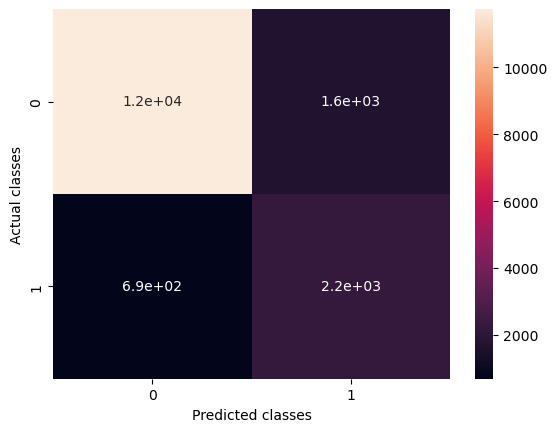

In [633]:
cfm = confusion_matrix(y_pred, y_test)
sns.heatmap(cfm, annot=True)
plt.xlabel('Predicted classes')
plt.ylabel('Actual classes')
print(cfm)